In [1]:
from numpy import *
from matplotlib.pyplot import *

In [2]:
#Thermal Conductivity
k1 = 0.27

#Thermal Diffusivity
gamma = 1.02*10**-7

#U0: Convection Coefficient
h = 5 #W/(m^2-K)

#Initial Tempurature
T0 = 21 #degC

#For Boundary
def B(r,dt):
    return dt*gamma*(2*h/(r*k1) - (r**2 * h**2 / (k1**2)))*T0

In [1]:
def delta(i,j):
    if i==j:
        return 1
    return 0

#Matrix that is built from the diffusion equation that evolves the tempurature.
def H(r,tha,gamma,dt,dr,dtha):
    a = gamma
    
    mat = zeros( (r.size,)*4 )
    for i in range(r.size):
        for j in range(tha.size):
            for k in range(r.size):
                for m in range(r.size):
                    value = a*dt*(
                        ( 1/(r[i]**2 * dtha**2) - cos(tha[j])/(r[i]**2 * sin(tha[j]) * dtha) ) * delta(i,k)*delta(j-1,m) +
                        
                        ( 1/(dr**2) - 2/(r[i]*dr) ) * delta(i-1,k)*delta(j,m) -
                        
                        ( 2/(dr**2) + 2/(r[i]**2 * dtha**2) - 1/(a*dt) ) * delta(i,k)*delta(j,m) +
                        
                        ( 1/(dr**2) + 2/(r[i]*dr) ) * delta(i+1,k)*delta(j,m) +
                        
                        ( cos(tha[j])/(r[i]**2 * sin(tha[j]) * dtha) + 1/(r[i]**2 * dtha**2) ) * delta(i,k)*delta(j+1,m)
                        )
                    
                    if i == 0:
                        value += a*dt*( ( 1/(dr**2) + 2/(r[i]*dr) ) * delta(i+1,k)*delta(j,m) )
                    
                    if j == 0:
                        value += a*dt*( ( 1/(r[i]**2 * dtha**2) - cos(tha[j])/(r[i]**2 * sin(tha[j]) * dtha) ) * delta(i,k)*delta(20,m) )
                        
                    if j == 20:
                        value += a*dt*( ( cos(tha[j])/(r[i]**2 * sin(tha[j]) * dtha) + 1/(r[i]**2 * dtha**2) ) * delta(i,k)*delta(0,m) )
                    
                    mat[i,j,k,m] = value
    return mat

#This is similar to the matrix above, except it is for the edge boundry conditions
def Hb(r,tha,gamma,dt,dr,dtha):
    a = gamma
    
    mat = zeros( (r.size,)*4 )
    for i in range(r.size):
        for j in range(tha.size):
            for k in range(r.size):
                for m in range(r.size):
                    value = a*dt*(
                        ( 1/(r[i]**2 * dtha**2) - cos(tha[j])/(r[i]**2 * sin(tha[j]) * dtha) ) * delta(i,k)*delta(j-1,m) -
                        
                        ( 2/(r[i]**2 * dtha**2) + 2*h/(r[i]*k1) - (r[i]**2 * h**2 / (k1**2)) - 1/(a*dt) ) * delta(i,k)*delta(j,m) +
                        
                        ( cos(tha[j])/(r[i]**2 * sin(tha[j]) * dtha) + 1/(r[i]**2 * dtha**2) ) * delta(i,k)*delta(j+1,m)
                        
                        )
                    
                    if j == 0:
                        value += a*dt*( ( 1/(r[i]**2 * dtha**2) - cos(tha[j])/(r[i]**2 * sin(tha[j]) * dtha) ) * delta(i,k)*delta(20,m) )
                        
                    if j == 20:
                        value += a*dt*( ( cos(tha[j])/(r[i]**2 * sin(tha[j]) * dtha) + 1/(r[i]**2 * dtha**2) ) * delta(i,k)*delta(0,m) )
                    
                    mat[i,j,k,m] = value
    return mat

#Sums the elements in the inputed matrix
def matsum(mat,x):
    add = 0
    for i in range(x.size):
        for j in range(x.size):
            add += mat[i,j]
    return add


#Creates new matrix T based on matrix H and the previous matrix T
def Tnew(mat1,mat2,mat3,q,x,dt):
    T = zeros( (x.size,x.size) )
    
    for i in range(x.size):
        for j in range(x.size):
            if i == x.size:
                A = multiply(mat3[:,:,i,j],mat2)
                add = matsum(A,x)
                T[i,j] = add + q[i,j] + B(x,dt)[i]
                
            else:
                A = multiply(mat1[:,:,i,j],mat2)
                add = matsum(A,x)
                T[i,j] = add + q[i,j]
    return T

#Creates a group of matrecies that is an array of T arrays where each matrix is a different time step
def Tnew_t(mat1,mat2,mat3,q,x,t,dt):
    T = zeros( (x.size,x.size,t.size) )
    T[:,:,0] = mat2
    
    for i in range(1,t.size):
        T[:,:,i] = Tnew(mat1,T[:,:,i-1],mat3,q,x,dt)
    return T

In [18]:
#Theta array and increment
tha = linspace(pi/20, 2*pi-pi/20, 20)
dtha = tha[1]-tha[0]

#r array and increment
s = 0.00025
r = linspace(s,20*s,20)
dr = s

#t array and increment
t = arange(1,11,1)
dt = 0.1*(dr**2/gamma * 0.2)

#All points initially at STP in Celcius
def Ti(r,tha):
    A = empty( (r.size,tha.size) )
    for i in range(r.size):
        for j in range(tha.size):
            A[i,j] = T0
    return A

Ti = Ti(r,tha)
q1 = dt*(gamma/k1)*random.random(size=(r.size,r.size))*10**8
#q1 = zeros( (r.size,r.size) )

In [24]:
dt

0.012254901960784314

In [20]:
Hmat = H(r,tha,gamma,dt,dr,dtha)
Hbmat = Hb(r,tha,gamma,dt,dr,dtha)
T = Tnew_t(Hmat,T0,Hbmat,q1,r,t,dt).round(2)

In [21]:
#Hmat[:,:,1,1]
#multiply(Hmat[:,:,0,0],T[:,:,0])

In [22]:
for i in range(r.size):
    for j in range(tha.size):
        for k in range(t.size):
            print(i,j,(tha[j]).round(3),t[k],T[i,j,k])

0 0 0.157 1 21.0
0 0 0.157 2 13.49
0 0 0.157 3 9.84
0 0 0.157 4 7.76
0 0 0.157 5 6.44
0 0 0.157 6 5.53
0 0 0.157 7 4.87
0 0 0.157 8 4.37
0 0 0.157 9 3.98
0 0 0.157 10 3.67
0 1 0.471 1 21.0
0 1 0.471 2 27.65
0 1 0.471 3 26.95
0 1 0.471 4 24.76
0 1 0.471 5 22.5
0 1 0.471 6 20.5
0 1 0.471 7 18.79
0 1 0.471 8 17.34
0 1 0.471 9 16.12
0 1 0.471 10 15.08
0 2 0.785 1 21.0
0 2 0.785 2 22.14
0 2 0.785 3 25.06
0 2 0.785 4 26.57
0 2 0.785 5 26.91
0 2 0.785 6 26.56
0 2 0.785 7 25.86
0 2 0.785 8 25.01
0 2 0.785 9 24.1
0 2 0.785 10 23.21
0 3 1.1 1 21.0
0 3 1.1 2 21.68
0 3 1.1 3 22.41
0 3 1.1 4 23.66
0 3 1.1 5 24.85
0 3 1.1 6 25.73
0 3 1.1 7 26.28
0 3 1.1 8 26.55
0 3 1.1 9 26.6
0 3 1.1 10 26.51
0 4 1.414 1 21.0
0 4 1.414 2 21.24
0 4 1.414 3 21.63
0 4 1.414 4 22.1
0 4 1.414 5 22.76
0 4 1.414 6 23.54
0 4 1.414 7 24.34
0 4 1.414 8 25.06
0 4 1.414 9 25.65
0 4 1.414 10 26.09
0 5 1.728 1 21.0
0 5 1.728 2 21.46
0 5 1.728 3 21.85
0 5 1.728 4 22.31
0 5 1.728 5 22.97
0 5 1.728 6 23.71
0 5 1.728 7 24.41
0 5 1.72

In [9]:
#T2 = zeros( (r.size,r.size) )
#A = multiply(Hmat[:,:,0,0],Ti)
#add = matsum(A,r)
#T2[0,0] = add

In [10]:
#Hmat[:,:,0,0]

In [11]:
#print(T[:,:,0])
#print( )
#print(T[:,:,1])
#print( )
#print(T[:,:,2])
#print( )
#print(T[:,:,3])
#print( )
#print(T[:,:,4])

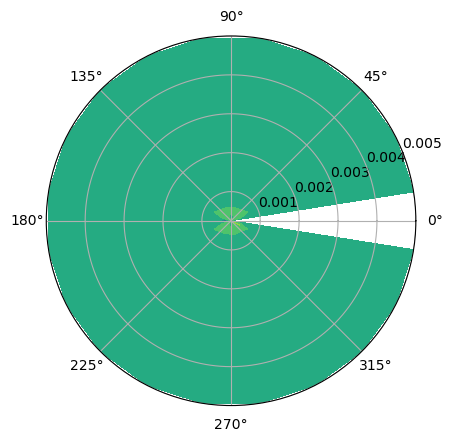

In [30]:
#----------------------------------------------------------------------------------------------------
# This is the graph for Stress R R
#=====================================================================================================
#-- Generate Data -----------------------------------------
# Using linspace so that the endpoint of 360 is included...
azimuths = tha
zeniths = r

R, theta = meshgrid(zeniths, azimuths)
values = transpose(T[:,:,1])


#-- Plot... ------------------------------------------------
fig, ax = subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, R, values)
#data = values
#plt.pcolormesh(data)
#plt.colorbar()

show()